# Education EDA
This notebook explores educational assessment data provided from NCES. The original datasets were achievement broken down by subject, Local Educational Agency (LEA), and school year. For now, we'll focus on 2017-18.

1. [Import Data](#Import-Data)

2. [Preview Data and Structure](#Preview-Data)

3.  [MATH ASSESSMENT](#Math-Assessment-Data)

4. [Reading & Language Arts (RLA) Assessment](#Reading-and-Language-Arts-Assessment)

[Census Broadband Dataa](#Census-Broadband-Data)

[Census Device Data](#Census-Device-Data)

[Geographical Data](#Geographical-Data)


# Import Data

In [1]:
## Import necessary modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import compress

In [2]:
## Import 2018 LEA  math data to start
math_2018 = pd.read_csv('../data/education/math-achievement-lea-sy2017-18.csv', low_memory=False)

In [3]:
## Preview dataset first 5
math_2018.head()

,STNAM,FIPST,LEAID,ST_LEAID,LEANM,DATE_CUR,ALL_MTH00NUMVALID_1718,ALL_MTH00PCTPROF_1718,MAM_MTH00NUMVALID_1718,MAM_MTH00PCTPROF_1718,...,MIL_MTH05NUMVALID_1718,MIL_MTH05PCTPROF_1718,MIL_MTH06NUMVALID_1718,MIL_MTH06PCTPROF_1718,MIL_MTH07NUMVALID_1718,MIL_MTH07PCTPROF_1718,MIL_MTH08NUMVALID_1718,MIL_MTH08PCTPROF_1718,MIL_MTHHSNUMVALID_1718,MIL_MTHHSPCTPROF_1718
0,ALABAMA,1,100005,AL-101,Albertville City,27MAR19,2892,45,5,PS,...,14,LT50,5,PS,11,GE50,14,GE50,10,GE50
1,ALABAMA,1,100006,AL-048,Marshall County,27MAR19,2987,43,12,GE50,...,1,PS,NaN,NaN,3,PS,2,PS,3,PS
2,ALABAMA,1,100007,AL-158,Hoover City,27MAR19,7551,70,5,PS,...,12,GE50,8,GE50,6,GE50,12,GE50,20,40-59
3,ALABAMA,1,100008,AL-169,Madison City,27MAR19,5668,76,47,60-69,...,34,60-69,38,70-79,42,60-69,51,70-79,44,70-79
4,ALABAMA,1,100011,AL-167,Leeds City,27MAR19,1017,40,2,PS,...,6,LT50,NaN,NaN,2,PS,4,PS,3,PS


In [4]:
math_2018.shape

(15984, 262)

#### Rows
There are almost 16,000 rows here. They appear to be unique observations for each Local Education Agency (LEA), but let's confirm:

In [5]:
## Ensure that LEAID is a unique value for each observation
math_2018['LEAID'].nunique() == math_2018.shape[0]
## Returns True if all values are unique

True

Great. Since the unique number of LEAIDs (15984) matches the total number of observations for the dataset, we know that it is a unique value. We can use this value as our index later.

#### Columns
To preview what's in them better, we'll look at just the columns to see if we can eliminate redundancies/noise.

The first set of columns contains identifying data:
- STNAME - State Name
- FIPST - ANSI 2-digit code for state
- LEAID - NCES-assigned District ID
- ST_LEAID - State-assigned District ID
- LEANM - District Name
- DATE_CUR - Date of data snapshot

And the rest contain various groupings of the data for each observation (LEA) in the following format:
- \[SUBGROUP\]_\[SUBJECT\]\[GRADE\]\[METRIC\]_\[SCHOOLYEAR\]

Reading the [documentation]('..\data\education\education_documentation_2018.docx) provides an overview of those columns, along with their corresponding meanings:

- **Subgroups** - Major Racial and Ethnic Groups / Special Populations
    - ALL - All Students in the school
    - Racial Subgroups (begin with M):
        - MAM American Indian/Alaska Native
        - MAS Asian/Pacific Islander
        - MHI Hispanic
        - MBL Black
        - MWH White
        - MTR Two or More Races
    - Special Population Subgroups:
        - CWD Children with disabilities
        - ECD Economically disadvantaged
        - LEP Limited English proficiency
        - HOM Homeless
        - MIG Migrant
        - FCS Foster Care Status
        - MIL Military Connected (new for '17-'18)
        
- **Subject** - Specific to each file.
    - Math (MTH) or Reading/Language Arts (RLA)
    
- **Grade** 
    - 00 - aggregated across all grades
    - 03-08 - Grades 3-8
    - HS - High School
    
- **Metric**
    - numvalid - # of students who completed assessment proficient
    - pctprof - % of students proficient or higher
    
- **School Year**
    - Limited to 2017-18 in this case
    - May be able to add additional years later for better understanding
    
So, for example, the column labeled "**MBL_MTH08PCTPROF_1718**" describes: 
- in 2017-18 **\[1718\]**,
- for Black students **\[MBL\]** 
- studying Math **\[MTH\]**
- in the Eighth grade **\[08\]**, 
- what Percentage were deemed Proficient **\[PCTPROF\]**



Knowing and observing this breakdown might prove helpful in improving the model later. For now, however, we'll keep only the following columns:
- LEAID - as our unique identifier / index. We'll convert this to a 7-digit string for concatenation.
- ALL_MTHHSPCTPROF_1718 - as our prediction column.

Given the business understanding and limitation to HS students, this makes sense. Since we don't have a total number of students who took the exam, percentage proficient will standardize the number proficient across districts.

## Math Assessment Data

In [6]:
def score_cleaner(score):
    score = str(score)
    
    if "-" in score:
        x, y = score.split("-")
        score = (int(x) + int(y))/ 2
        return round(int((score)))
    
#     elif "GT" or "GE" in score:
#         if "GT" in score:
#             score = score.strip("GT")
#             score = (100 - int(score))/2
#             return round(int((score)))

#         elif "GE" in score:
#             score = score.strip("GE")
#             score = (100 - int(score))/2
#             return round(int((score)))
    
#     elif "LT" or "LE" in score:
#         if "LT" in score:
#             score = score.strip("LT")
#             score = (0 + int(score))/2
#             return round(int((score)))

#         elif "LE" in score:
#             score = score.strip("LE")
#             score = (0 + int(score))/2
#             return round(int((score)))
    else:
        return int(score)

In [8]:
## Create new dataframe with just the two desired columns
all_math_2018 = math_2018[['LEAID','ALL_MTHHSPCTPROF_1718']].dropna()
all_math_2018.columns = all_math_2018.columns.str.lower()
all_math_2018.rename(columns={'all_mthhspctprof_1718': 'math_score'}, inplace=True)
all_math_2018.leaid = all_math_2018.leaid.apply(str)
all_math_2018.math_score = all_math_2018.math_score.apply(str)
all_math_2018.leaid = all_math_2018.leaid.str.zfill(7)
all_math_2018 = pd.DataFrame(data=all_math_2018)
print(all_math_2018.head())
print(all_math_2018.info())

     leaid math_score
0  0100005         37
1  0100006         43
2  0100007         70
3  0100008         75
4  0100011      50-54
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12358 entries, 0 to 15983
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   leaid       12358 non-null  object
 1   math_score  12358 non-null  object
dtypes: object(2)
memory usage: 289.6+ KB
None


In [9]:
PS_values = all_math_2018[all_math_2018['math_score'] == "PS" ].index
period_values = all_math_2018[all_math_2018['math_score'] == "." ].index
LE_values = all_math_2018[all_math_2018.math_score.str.contains("LE")].index
GT_values = all_math_2018[all_math_2018.math_score.str.contains("GE")].index
GE_values = all_math_2018[all_math_2018.math_score.str.contains("GT")].index
LT_values = all_math_2018[all_math_2018.math_score.str.contains("LT")].index

all_math_2018.drop(PS_values, inplace = True)
all_math_2018.drop(period_values, inplace = True)
all_math_2018.drop(LT_values, inplace = True)
all_math_2018.drop(LE_values, inplace = True)
all_math_2018.drop(GT_values, inplace = True)
all_math_2018.drop(GE_values, inplace = True)
all_math_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9044 entries, 0 to 15983
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   leaid       9044 non-null   object
 1   math_score  9044 non-null   object
dtypes: object(2)
memory usage: 532.0+ KB


In [10]:
all_math_2018.math_score = all_math_2018.math_score.apply(score_cleaner)
all_math_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9044 entries, 0 to 15983
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   leaid       9044 non-null   object
 1   math_score  9044 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 532.0+ KB


In [11]:
# all_math_2018.math_score = all_math_2018.loc[~all_math_2018.math_score.str.contains("LT"),:]
# all_math_2018.dropna(inplace=True)
# all_math_2018.math_score = all_math_2018.loc[~all_math_2018.math_score.str.contains("GE"),:]
# all_math_2018.dropna(inplace=True)
# all_math_2018.math_score = all_math_2018.loc[~all_math_2018.math_score.str.contains("GT"),:]
# all_math_2018.dropna(inplace=True)

# all_math_2018.head()

This dataset is much cleaner. 

However, looking closer at the target variable column we have two issues in the target variable column:
1. Null values - around 3600
2. Datatype - is classified as object

Not only is the target variable classified as an object, but looking at the 5th observation, the objects do not appear to be readily convertible to integers, since some of them appear to be ranges. Taking a further look:

In [12]:
all_math_2018['math_score'].unique()

array([37, 43, 70, 75, 52, 42, 73, 47, 27, 72, 32, 57, 24, 62, 58, 53, 12,
       18, 46, 40, 38, 17, 77, 22, 35, 39, 34, 44,  7, 82, 31, 50, 41, 55,
       45, 91, 61, 33,  5, 30, 15, 25, 69, 23, 49, 64, 54, 84, 51, 74, 67,
       16, 28, 92, 21, 36, 65, 66, 56, 48, 60, 59, 20,  6, 87,  8, 29, 10,
       26, 63, 68, 71, 19, 13, 14,  9, 86,  4, 11, 81, 78, 79, 83,  2, 76,
       80, 90, 95, 88, 85, 96, 89, 93, 97, 94,  3, 98], dtype=int64)

Further inspection reveals that "nan" values, "." values (also described as blank in documentation),  ranges, and strings are complicating the numerical analysis. Referring again to the documentation, these variations were intentionally introduced for student privacy concerns, with the following codes:

- GE - Greater than or equal to
- LE - Less than or equal to
- GT Greater than
- LT - Less than
- PS - Privacy Suppressed (<5 students)

Specifically, as specified in Part 1.5 and Table 2 of the documentation for 2017-18, for schools with less than 300 students, "As the number of students reported increases, the magnitude of the range decreases". 

Given these ranges, we can make a few choices:

1. Limit the study to large high schools (300+). 
    - Benefit: Leaves only whole numbers, enabling integer conversion. 
    - Benefit: Allows for the possible usage of linear regression since it would be a continuous variable
    - Cost: Eliminates the potential for analyzing size as a factor; Unnecessarily eliminates data
    

2. Bin the score ranges...more options here: 
    - Smaller scale (e.g., 25-29)
    - Medium-scale (e.g., Very High proficiency (>80%), high proficiency (60-80), proficient (40-60), low proficiency (20-40), very low proficiency (0-20)
    - Large scale (e.g., >= 50% as proficient)
    

For now, let's focus on large high schools. In this dataset, this means limiting the observations selected to those with 1 or 2 characters that are not "PS":

array([[<AxesSubplot:title={'center':'math_score'}>]], dtype=object)

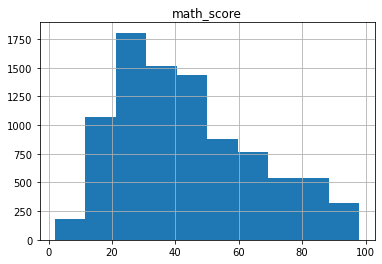

In [16]:
all_math_2018.hist()

Unfortunately, using only the schools that hadn't been "blurred" will result in too few datapoints. For now, though, let's continue by repeating this procedure for Reading and Language Arts data (RLA).

## Reading and Language Arts Assessment

In [19]:
rla_2018 = pd.read_csv('../data/education/rla-achievement-lea-sy2017-18.csv', low_memory=False)

## Create new dataframe with just the two desired columns
all_rla_2018 = rla_2018[['LEAID','ALL_RLAHSPCTPROF_1718']].dropna()
all_rla_2018.columns = all_rla_2018.columns.str.lower()
all_rla_2018.rename(columns={'all_rlahspctprof_1718': 'rla_score'}, inplace=True)
all_rla_2018.leaid = all_rla_2018.leaid.apply(str)
all_rla_2018.rla_score = all_rla_2018.rla_score.apply(str)
all_rla_2018.leaid = all_rla_2018.leaid.str.zfill(7)
all_rla_2018 = pd.DataFrame(data=all_rla_2018)
print(all_rla_2018.head())
print(all_rla_2018.info())

     leaid rla_score
0  0100005        32
1  0100006        40
2  0100007        69
3  0100008        71
4  0100011     45-49
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12487 entries, 0 to 16109
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   leaid      12487 non-null  object
 1   rla_score  12487 non-null  object
dtypes: object(2)
memory usage: 292.7+ KB
None


In [20]:
rla_2018.head()

,STNAM,FIPST,LEAID,ST_LEAID,LEANM,DATE_CUR,ALL_RLA00NUMVALID_1718,ALL_RLA00PCTPROF_1718,MAM_RLA00NUMVALID_1718,MAM_RLA00PCTPROF_1718,...,MIL_RLA05NUMVALID_1718,MIL_RLA05PCTPROF_1718,MIL_RLA06NUMVALID_1718,MIL_RLA06PCTPROF_1718,MIL_RLA07NUMVALID_1718,MIL_RLA07PCTPROF_1718,MIL_RLA08NUMVALID_1718,MIL_RLA08PCTPROF_1718,MIL_RLAHSNUMVALID_1718,MIL_RLAHSPCTPROF_1718
0,ALABAMA,1,100005,AL-101,Albertville City,27MAR19,2885,38,5,PS,...,14,LT50,5,PS,11,GE50,14,GE50,10,GE50
1,ALABAMA,1,100006,AL-048,Marshall County,27MAR19,2984,36,12,GE50,...,1,PS,NaN,NaN,3,PS,2,PS,3,PS
2,ALABAMA,1,100007,AL-158,Hoover City,27MAR19,7522,65,5,PS,...,11,GE50,8,GE50,6,GE50,12,GE50,20,40-59
3,ALABAMA,1,100008,AL-169,Madison City,27MAR19,5654,74,46,50-59,...,34,80-89,38,70-79,42,70-79,51,70-79,44,60-69
4,ALABAMA,1,100011,AL-167,Leeds City,27MAR19,1017,41,2,PS,...,6,LT50,NaN,NaN,2,PS,4,PS,3,PS


In [21]:
PS_values = all_rla_2018[all_rla_2018['rla_score'] == "PS" ].index
period_values = all_rla_2018[all_rla_2018['rla_score'] == "." ].index
LE_values = all_rla_2018[all_rla_2018.rla_score.str.contains("LE")].index
GT_values = all_rla_2018[all_rla_2018.rla_score.str.contains("GE")].index
GE_values = all_rla_2018[all_rla_2018.rla_score.str.contains("GT")].index
LT_values = all_rla_2018[all_rla_2018.rla_score.str.contains("LT")].index

all_rla_2018.drop(PS_values, inplace = True)
all_rla_2018.drop(period_values, inplace = True)
all_rla_2018.drop(LT_values, inplace = True)
all_rla_2018.drop(LE_values, inplace = True)
all_rla_2018.drop(GT_values, inplace = True)
all_rla_2018.drop(GE_values, inplace = True)
all_rla_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9655 entries, 0 to 16109
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   leaid      9655 non-null   object
 1   rla_score  9655 non-null   object
dtypes: object(2)
memory usage: 546.3+ KB


In [22]:
all_rla_2018.rla_score = all_rla_2018.rla_score.apply(score_cleaner)
all_rla_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9655 entries, 0 to 16109
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   leaid      9655 non-null   object
 1   rla_score  9655 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 546.3+ KB


In [28]:
all_rla_2018.head()

,leaid,rla_score
0,0100005,32
1,0100006,40
2,0100007,69
3,0100008,71
4,0100011,47


In [39]:
hs_assessments_2018 = pd.merge(all_rla_2018, all_math_2018, how='inner', on='leaid').dropna()
hs_assessments_2018['year'] = 2018
hs_assessments_2018.info

<bound method DataFrame.info of         leaid  rla_score  math_score  year
0     0100005         32          37  2018
1     0100006         40          43  2018
2     0100007         69          70  2018
3     0100008         71          75  2018
4     0100011         47          52  2018
...       ...        ...         ...   ...
8696  5605762         52          40  2018
8697  5605820         49          49  2018
8698  5605830         60          58  2018
8699  5606090         44          44  2018
8700  5606240         62          47  2018

[8701 rows x 4 columns]>

In [40]:
hs_assessments_2018.to_pickle('../data/education/hs_assessments_2018.pkl')

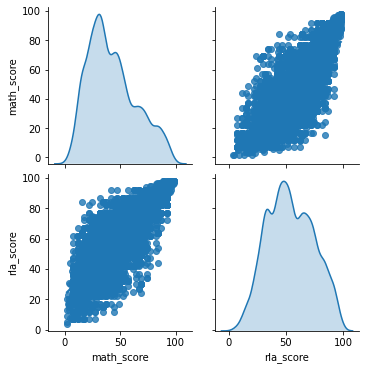

In [26]:
sns.pairplot(assessments_2018, vars=['math_score', 'rla_score'], kind='reg', diag_kind='kde');

As is probably expected, there is a definite correlation between Reading/Language Arts Scores and Math Scores for the limited dataset we're observing. It should be noted that the math score distribution skews slightly to the left. The RLA score skews to the right. This phenomenon is confirmed in the statistical summary which shows us that the mean math score is 45% and the mean reading/language arts score is 55%.

### K-12

#### k-12 math

In [41]:
whole_math_2018 = math_2018[['LEAID','ALL_MTH00PCTPROF_1718']].dropna()
whole_math_2018.columns = whole_math_2018.columns.str.lower()
whole_math_2018.rename(columns={'all_mth00pctprof_1718': 'math_score'}, inplace=True)
whole_math_2018.leaid = whole_math_2018.leaid.apply(str)
whole_math_2018.math_score = whole_math_2018.math_score.apply(str)
whole_math_2018.leaid = whole_math_2018.leaid.str.zfill(7)
whole_math_2018 = pd.DataFrame(data=whole_math_2018)
print(whole_math_2018.head())
print(whole_math_2018.info())

     leaid math_score
0  0100005         45
1  0100006         43
2  0100007         70
3  0100008         76
4  0100011         40
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15984 entries, 0 to 15983
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   leaid       15984 non-null  object
 1   math_score  15984 non-null  object
dtypes: object(2)
memory usage: 374.6+ KB
None


In [42]:
PS_values = whole_math_2018[whole_math_2018['math_score'] == "PS" ].index
period_values = whole_math_2018[whole_math_2018['math_score'] == "." ].index
LE_values = whole_math_2018[whole_math_2018.math_score.str.contains("LE")].index
GT_values = whole_math_2018[whole_math_2018.math_score.str.contains("GE")].index
GE_values = whole_math_2018[whole_math_2018.math_score.str.contains("GT")].index
LT_values = whole_math_2018[whole_math_2018.math_score.str.contains("LT")].index

whole_math_2018.drop(PS_values, inplace = True)
whole_math_2018.drop(period_values, inplace = True)
whole_math_2018.drop(LT_values, inplace = True)
whole_math_2018.drop(LE_values, inplace = True)
whole_math_2018.drop(GT_values, inplace = True)
whole_math_2018.drop(GE_values, inplace = True)
whole_math_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14932 entries, 0 to 15983
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   leaid       14932 non-null  object
 1   math_score  14932 non-null  object
dtypes: object(2)
memory usage: 990.0+ KB


In [44]:
whole_math_2018.math_score = whole_math_2018.math_score.apply(score_cleaner)
whole_math_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14932 entries, 0 to 15983
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   leaid       14932 non-null  object
 1   math_score  14932 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 990.0+ KB


In [45]:
whole_math_2018.to_pickle('../data/education/whole_math_2018.pkl')

#### k-12 rla

In [33]:
## Create new dataframe with just the two desired columns

whole_rla_2018 = rla_2018[['LEAID','ALL_RLA00PCTPROF_1718']].dropna()
whole_rla_2018.columns = whole_rla_2018.columns.str.lower()
whole_rla_2018.rename(columns={'all_rla00pctprof_1718': 'rla_score'}, inplace=True)
whole_rla_2018.leaid = whole_rla_2018.leaid.apply(str)
whole_rla_2018.rla_score = whole_rla_2018.rla_score.apply(str)
whole_rla_2018.leaid = whole_rla_2018.leaid.str.zfill(7)
whole_rla_2018 = pd.DataFrame(data=whole_rla_2018)
print(whole_rla_2018.head())
print(whole_rla_2018.info())

     leaid rla_score
0  0100005        38
1  0100006        36
2  0100007        65
3  0100008        74
4  0100011        41
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16110 entries, 0 to 16109
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   leaid      16110 non-null  object
 1   rla_score  16110 non-null  object
dtypes: object(2)
memory usage: 377.6+ KB
None


In [35]:
PS_values = whole_rla_2018[whole_rla_2018['rla_score'] == "PS" ].index
period_values = whole_rla_2018[whole_rla_2018['rla_score'] == "." ].index
LE_values = whole_rla_2018[whole_rla_2018.rla_score.str.contains("LE")].index
GT_values = whole_rla_2018[whole_rla_2018.rla_score.str.contains("GE")].index
GE_values = whole_rla_2018[whole_rla_2018.rla_score.str.contains("GT")].index
LT_values = whole_rla_2018[whole_rla_2018.rla_score.str.contains("LT")].index

whole_rla_2018.drop(PS_values, inplace = True)
whole_rla_2018.drop(period_values, inplace = True)
whole_rla_2018.drop(LT_values, inplace = True)
whole_rla_2018.drop(LE_values, inplace = True)
whole_rla_2018.drop(GT_values, inplace = True)
whole_rla_2018.drop(GE_values, inplace = True)
whole_rla_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15245 entries, 0 to 16109
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   leaid      15245 non-null  object
 1   rla_score  15245 non-null  object
dtypes: object(2)
memory usage: 997.3+ KB


In [37]:
whole_rla_2018.rla_score = whole_rla_2018.rla_score.apply(score_cleaner)
whole_rla_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15245 entries, 0 to 16109
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   leaid      15245 non-null  object
 1   rla_score  15245 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 997.3+ KB


In [43]:
whole_rla_2018.to_pickle('../data/education/whole_rla_2018.pkl')

#### k-12 combined

In [46]:
combined_assessments_2018 = pd.merge(whole_rla_2018, whole_math_2018, how='inner', on='leaid').dropna()
combined_assessments_2018['year'] = 2018
combined_assessments_2018.info

<bound method DataFrame.info of          leaid  rla_score  math_score  year
0      0100005         38          45  2018
1      0100006         36          43  2018
2      0100007         65          70  2018
3      0100008         74          76  2018
4      0100011         41          40  2018
...        ...        ...         ...   ...
14869  5605762         57          56  2018
14870  5605820         64          64  2018
14871  5605830         61          55  2018
14872  5606090         52          42  2018
14873  5606240         63          57  2018

[14874 rows x 4 columns]>

In [47]:
combined_assessments_2018.to_pickle('../data/education/combined_assessments_2018.pkl')

## Census Broadband Data

## Census Device Data

## Geographical Data